<img src="https://devra.ai/analyst/notebook/1792/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;"><div style="font-size:150%; color:#FEE100"><b>Satellite Telemetry Data Anomaly Analysis and Prediction Notebook</b></div>

I have always found it fascinating how raw telemetry data can hide subtle signals of anomalies. In this notebook, we explore a satellite telemetry dataset, perform extensive exploratory data analysis, and build a predictor to detect anomalies in the data. 

# > Table of Contents

- [Data Overview](#Data-Overview)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Prediction Model](#Prediction-Model)

In [8]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Using Agg backend for matplotlib if necessary it is used to plot to files it doesn't open a GUI 
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Switch backend if only plt is imported

import seaborn as sns

# For machine learning
from sklearn.ensemble import RandomForestClassifier  #Ensemble-based methods for classification, regression and anomaly detection.
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# Ensure inline plotting on Kaggle
%matplotlib inline

# Set plot style
sns.set(style='whitegrid')


## Data Overview

In [9]:
# Load segments.csv
# This file contains individual telemetry segments along with timestamps.
segments_path = './data/segments.csv'
segments_df = pd.read_csv(segments_path)

# Display the first few rows to understand the structure
print('Segments DataFrame Shape:', segments_df.shape)
print(segments_df.head())

# Convert the timestamp column to datetime if it is not already converted
# This is a common error point if the timestamp is not in a standard format
try:
    segments_df['timestamp'] = pd.to_datetime(segments_df['timestamp'])
except Exception as e:
    print('Error converting timestamp to datetime:', e)
    # Note: Using pd.to_datetime with errors='coerce' might be an alternative method to avoid conversion errors.

# Check the data types after conversion
print(segments_df.dtypes)

Segments DataFrame Shape: (303493, 8)
    channel                 timestamp     value    label  sampling  anomaly  \
0  CADC0872  2022-06-01T23:42:54.000Z -0.000021  anomaly         1        1   
1  CADC0872  2022-06-01T23:42:55.000Z -0.000021  anomaly         1        1   
2  CADC0872  2022-06-01T23:42:56.000Z -0.000021  anomaly         1        1   
3  CADC0872  2022-06-01T23:42:57.000Z -0.000021  anomaly         1        1   
4  CADC0872  2022-06-01T23:42:58.000Z -0.000021  anomaly         1        1   

   segment  train  
0        1      1  
1        1      1  
2        1      1  
3        1      1  
4        1      1  
channel                   object
timestamp    datetime64[ns, UTC]
value                    float64
label                     object
sampling                   int64
anomaly                    int64
segment                    int64
train                      int64
dtype: object


## Data Cleaning and Preprocessing

In [10]:
# Load dataset.csv
# This file provides aggregated features for each segment including statistical summaries
dataset_path = './data/ready_data.csv'

df = pd.read_csv(dataset_path)

# Inspect the first few rows and summary information
print('Dataset Shape:', df.shape)
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

# No explicit cleaning needed if there are no missing values. If there are, methods such as imputation could be applied.

Dataset Shape: (2123, 13)
   anomaly  train  duration          mean           var  kurtosis      skew  \
0        1      1       279  8.533143e-07  3.494283e-10  0.631117  0.552052   
1        1      1       476 -3.639396e-06  6.476485e-10 -1.243611  0.425632   
2        1      1       594  1.170788e-05  5.592877e-10 -0.284593 -0.826187   
3        1      1       271  8.486808e-07  5.466024e-10 -0.887088 -0.138498   
4        0      0       255  1.058485e-05  5.279023e-10 -1.484393 -0.060155   

   n_peaks  smooth10_n_peaks  smooth20_n_peaks  diff_peaks      diff_var  \
0        4                 3                 2           4  1.271176e-10   
1        1                 1                 1           5  1.489383e-12   
2        3                 2                 2           2  4.112280e-12   
3        2                 2                 2           3  2.475760e-11   
4        1                 1                 1          78  5.547101e-13   

   gaps_squared  
0           309  
1     

## Exploratory Data Analysis

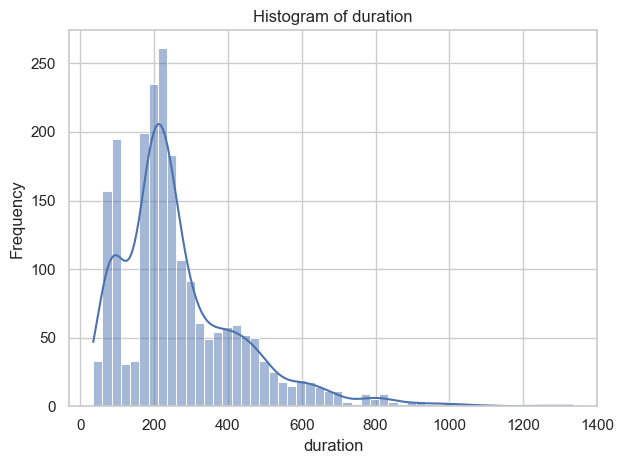

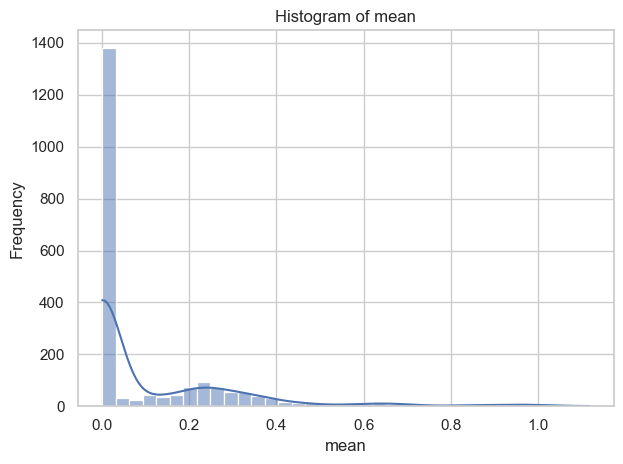

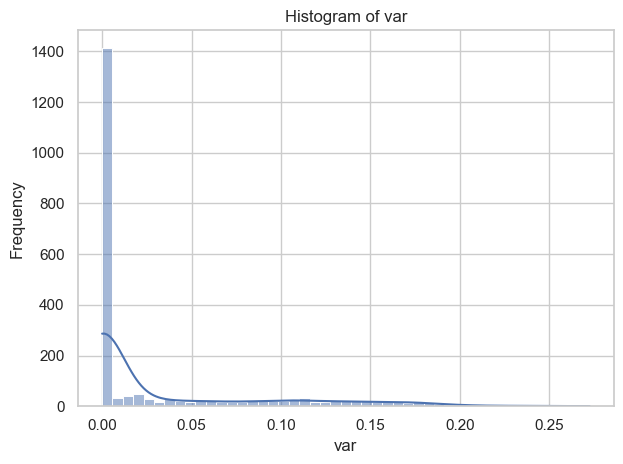

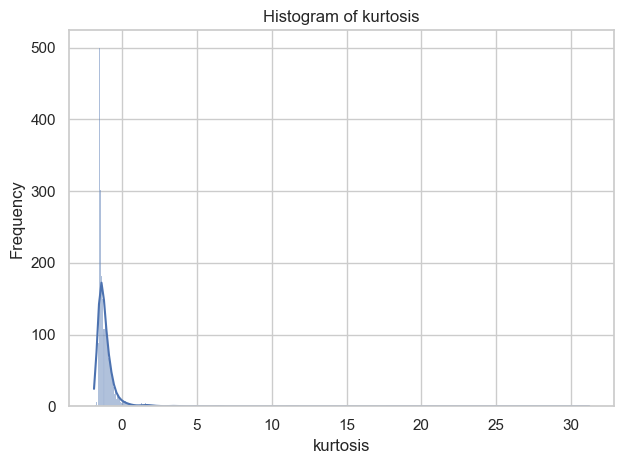

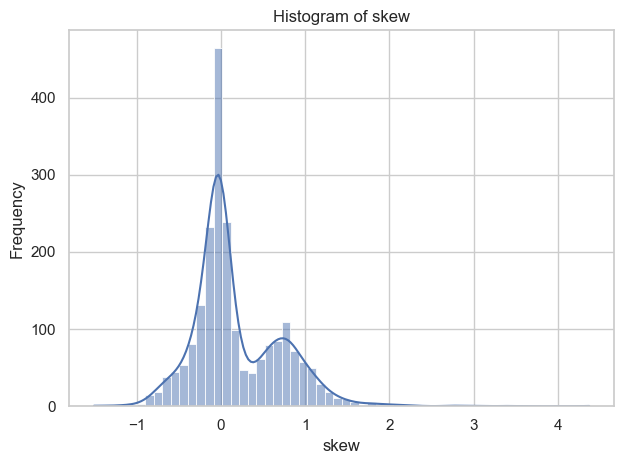

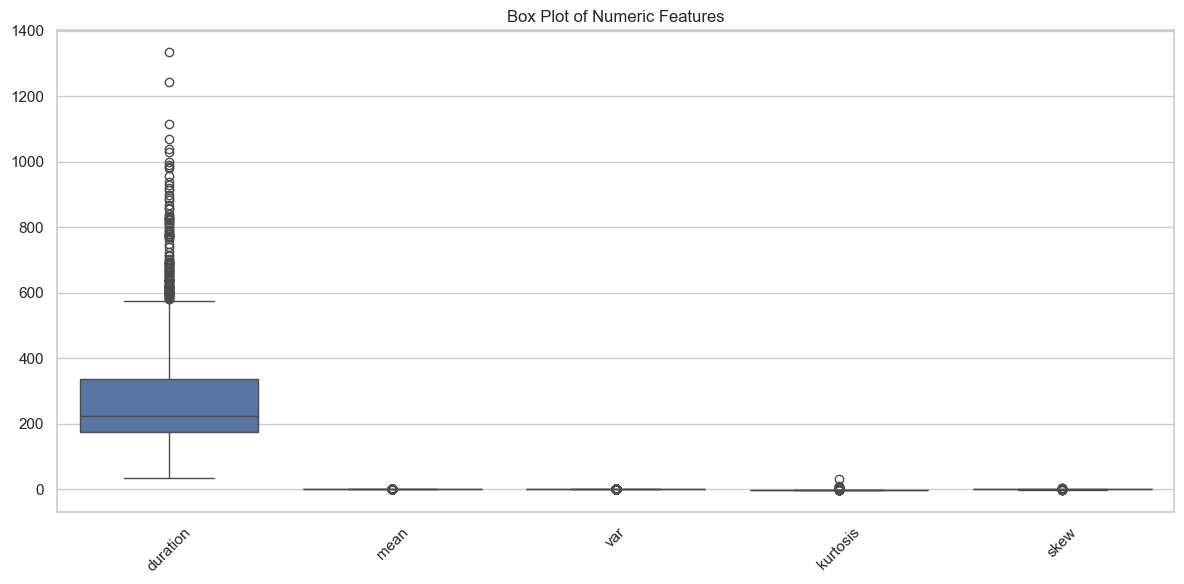

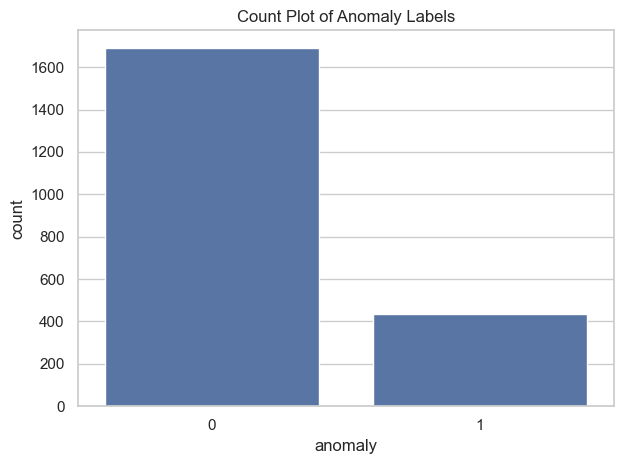

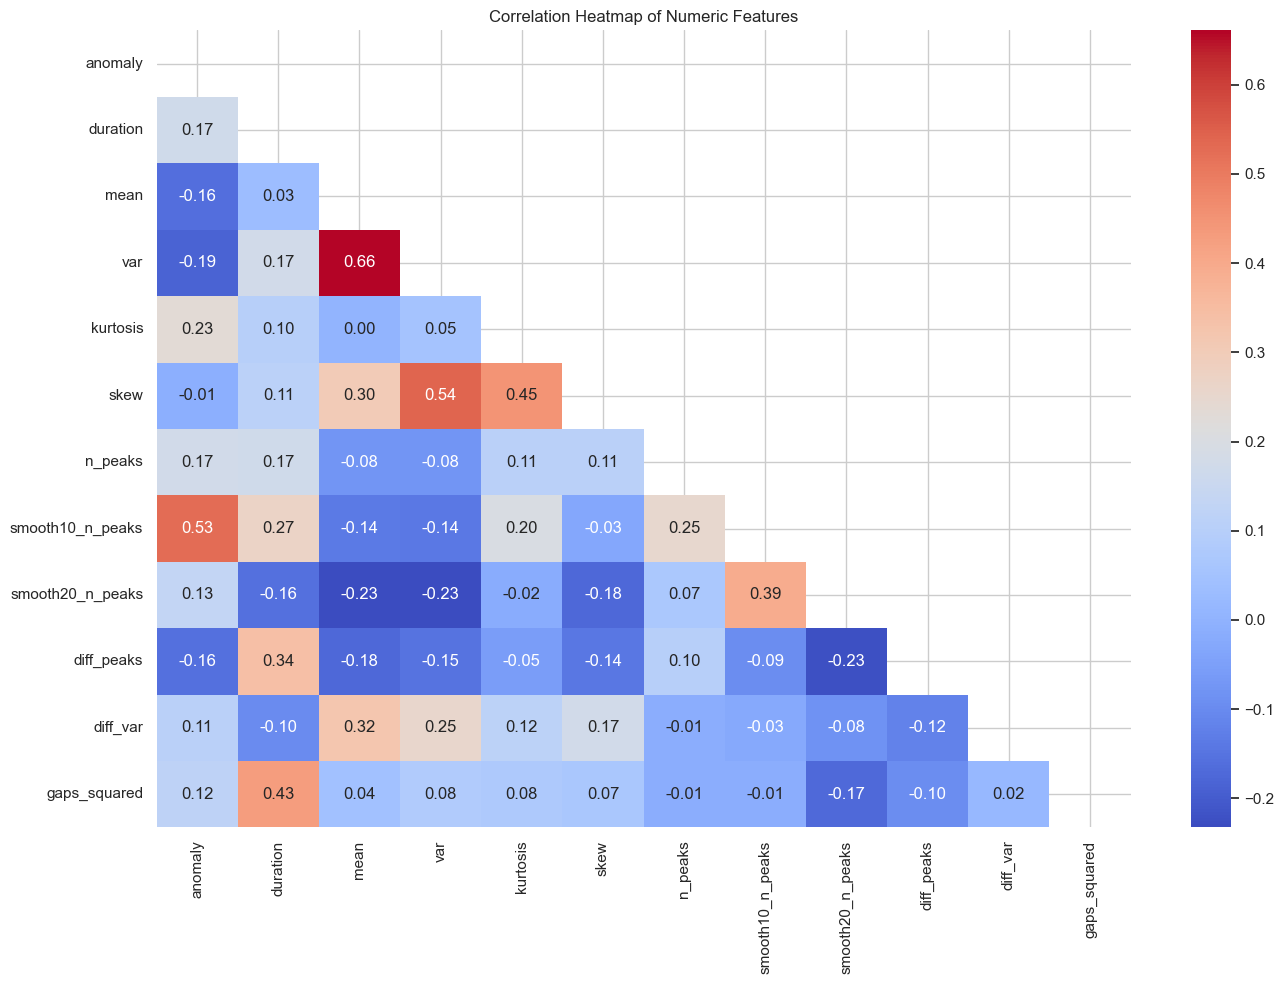

Series([], dtype: float64)


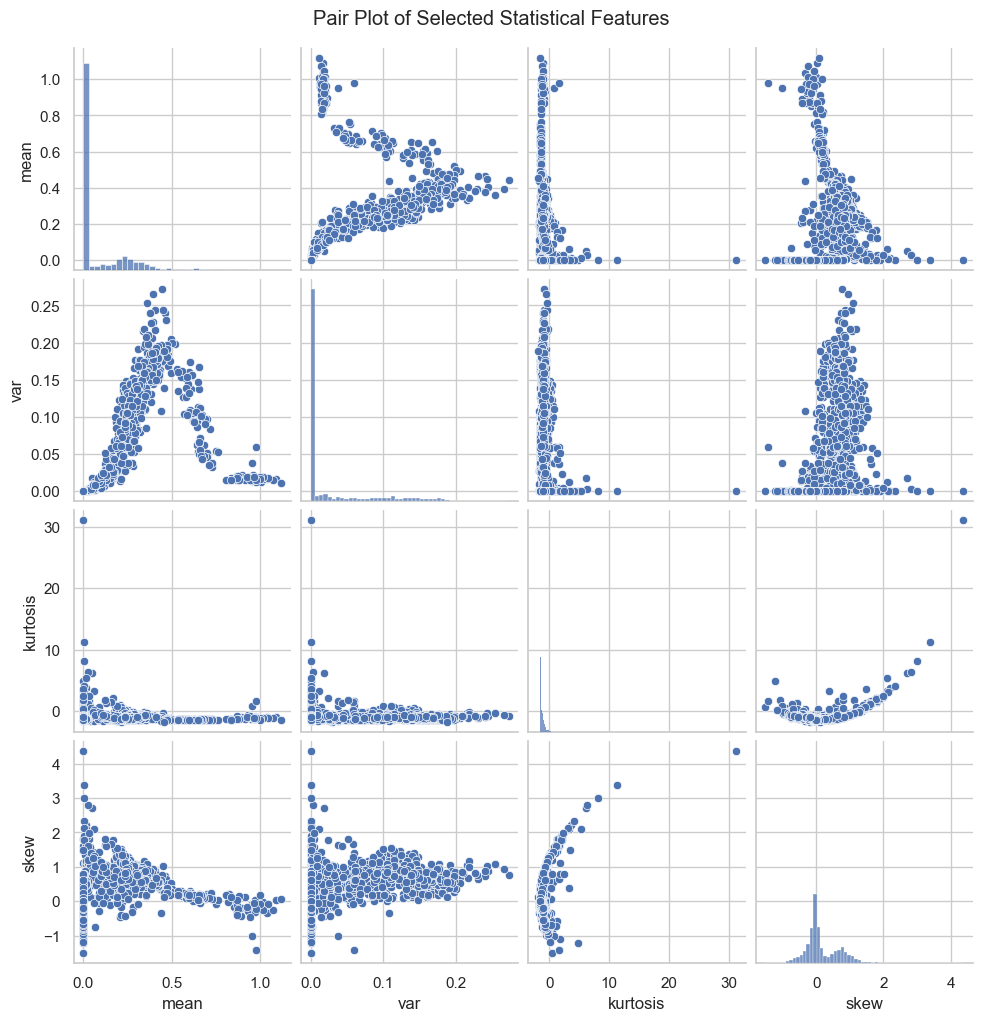

In [11]:
# Let's perform a variety of visualizations on the dataset

## Histogram of select numeric features
numeric_features = ['duration', 'mean', 'var', 'kurtosis', 'skew']
for feature in numeric_features:
    plt.figure()
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## Box Plot for numeric features to view outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.title('Box Plot of Numeric Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Count Plot for anomaly labels
plt.figure()
sns.countplot(x='anomaly', data=df)
plt.title('Count Plot of Anomaly Labels')
plt.tight_layout()
plt.show()

## Correlation Heatmap (only if 4 or more numeric columns are present)
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=['train'])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(14, 10))
    corr = numeric_df.corr()
    matrix = corr
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
    
    
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
matrix = matrix.unstack()
print(matrix[(abs(matrix) >= 0.8) & (abs(matrix) < 1)])

## Pair Plot for visualizing relationships between select features
sample_features = ['mean', 'var', 'kurtosis', 'skew']
sns.pairplot(df[sample_features].dropna())
plt.suptitle('Pair Plot of Selected Statistical Features', y=1.02)
plt.show()

# Note: In some cases, if there are too many features, pair plots may become cluttered. Use with a small subset.

## Prediction Model

In [12]:
excluded_cols = ['train', 'anomaly']
features = [col for col in df.columns if col not in excluded_cols]

print(features)

# Split into train and test
train_df = df[df['train'] == 1].copy()
test_df = df[df['train'] == 0].copy()

display(train_df)
display(test_df)

# Ensure only numeric features and consistent columns
train_X = train_df[features].select_dtypes(include=[np.number])
test_X = test_df[features].select_dtypes(include=[np.number])

train_y = train_df['anomaly']
test_y = test_df['anomaly']

# Train RandomForest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(train_X, train_y)


['duration', 'mean', 'var', 'kurtosis', 'skew', 'n_peaks', 'smooth10_n_peaks', 'smooth20_n_peaks', 'diff_peaks', 'diff_var', 'gaps_squared']


,anomaly,train,duration,mean,var,kurtosis,skew,n_peaks,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff_var,gaps_squared
0,1,1,279,8.533143e-07,3.494283e-10,0.631117,0.552052,4,3,2,4,1.271176e-10,309
1,1,1,476,-3.639396e-06,6.476485e-10,-1.243611,0.425632,1,1,1,5,1.489383e-12,644
2,1,1,594,1.170788e-05,5.592877e-10,-0.284593,-0.826187,3,2,2,2,4.112280e-12,772
3,1,1,271,8.486808e-07,5.466024e-10,-0.887088,-0.138498,2,2,2,3,2.475760e-11,339
5,0,1,252,6.326025e-06,6.643180e-10,-1.302309,-0.179240,1,1,1,66,6.430575e-13,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,0,1,160,-2.909492e-05,1.098482e-10,-1.521725,0.013472,1,1,1,2,4.288093e-12,800
2119,0,1,165,-2.318618e-05,1.988522e-10,-1.490978,-0.038516,1,1,1,4,7.349826e-12,825
2120,0,1,140,-3.137510e-05,1.146533e-10,-1.504177,0.013923,1,1,1,3,5.763149e-12,700
2121,0,1,200,-5.376693e-06,7.755461e-10,-1.470041,-0.002828,1,1,1,2,1.837184e-11,1000


,anomaly,train,duration,mean,var,kurtosis,skew,n_peaks,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff_var,gaps_squared
4,0,0,255,0.000011,5.279023e-10,-1.484393,-0.060155,1,1,1,78,5.547101e-13,357
6,0,0,378,0.000003,3.843725e-10,-0.736379,-0.078294,1,1,1,111,3.793821e-13,528
11,0,0,238,0.000008,6.720665e-10,-1.477101,-0.044238,1,1,1,66,8.337572e-13,238
12,1,0,229,-0.000002,6.086603e-10,-0.812623,0.389746,1,1,1,1,9.853793e-12,229
17,0,0,213,-0.000001,2.435483e-10,-1.086335,-0.321541,1,1,1,47,1.554131e-12,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,0,0,75,-0.000008,4.211976e-10,-1.475363,-0.027797,1,1,2,1,6.822508e-11,375
2110,0,0,145,-0.000027,1.306827e-10,-1.199398,-0.217889,1,1,1,5,5.665315e-12,725
2113,0,0,145,0.000009,2.502306e-10,-0.788751,-0.651451,1,1,1,2,6.690331e-12,725
2115,0,0,145,0.000027,6.269720e-11,-0.971084,-0.534071,1,1,1,5,2.455740e-12,725


RandomForestClassifier(random_state=42)

Test Accuracy: 0.9622


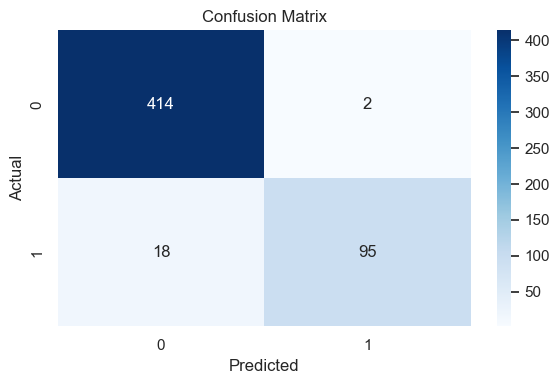

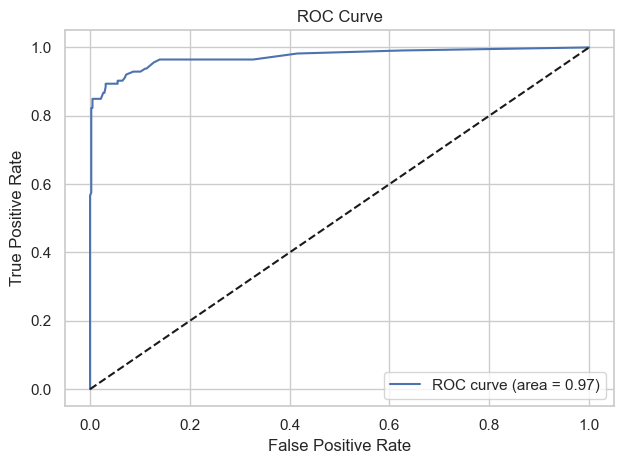

In [13]:
y_test_pred = rfc.predict(test_X)
accuracy = accuracy_score(test_y, y_test_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Compute and plot the confusion matrix
cm = confusion_matrix(test_y, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot ROC Curve for a visual assessment
y_test_prob = rfc.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_test_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, average_precision_score


def evaluate_metrics(y_test, y_pred, y_proba=None, digits=3):
    res = {"Accuracy": round(accuracy_score(y_test, y_pred), digits),
           "Precision": precision_score(y_test, y_pred).round(digits),
           "Recall": recall_score(y_test, y_pred).round(digits),
           "F1": f1_score(y_test, y_pred).round(digits),
           "MCC": round(matthews_corrcoef(y_test, y_pred), ndigits=digits)}
    if y_proba is not None:
        res["AUC_PR"] = average_precision_score(y_test, y_proba).round(digits)
        res["AUC_ROC"] = roc_auc_score(y_test, y_proba).round(digits)
    return res

print(rfc, '\n', evaluate_metrics(test_y, y_test_pred, y_test_prob))

RandomForestClassifier(random_state=42) 
 {'Accuracy': 0.962, 'Precision': 0.979, 'Recall': 0.841, 'F1': 0.905, 'MCC': 0.885, 'AUC_PR': 0.948, 'AUC_ROC': 0.973}
